# Building Data generator

In [54]:
import pandas as pd
import numpy as np
from typing import Union
from tensorflow.keras.utils import Sequence, to_categorical # For our own data generator
import cv2 # For image processing
import matplotlib.pyplot as plt # for showing the val vs train model
from tensorflow.keras.callbacks import ModelCheckpoint

In [317]:
class DataGenerator_array(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    #https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c
    """
    def __init__(self,
                 x: Union[pd.DataFrame, np.array],
                 y: Union[pd.DataFrame, np.array] = None, #'grapheme_root','vowel_diacritic','consonant_diacritic' 
                 encoder: bool = None,
                 to_fit: bool =True,
                 batch_size: int = 32,
                 dim: tuple = (90,160),
                 channels: int = 1,
                 vertical_flip: float = 0,
                 horizontal_flip: float = 0,
                 rotate: tuple = (0,0), #Prob, max roatioan
                 shear: tuple = (0,0),  #prob, max_shear
                 noise: tuple = (0,0), #mean, STD (127, 40)
                 shuffle: bool =True,
                 sample_classes: int = 0,
                 save_model_path: bool = None):
        """Initialization of the DataGenerator Glass
        
        Arguments:
            x - {DataFrame/Array} - the array/dataframe of the dependant images 
            y_var - {Dataframe/Array} - the column name/index of the y-var
            encoder - {bool} - should the Y var be encoded
            to_fit - {bool} - if using to fit the model, should it return the y-value as well?
            batch_size - {int} - size of batches to deliver
            dim - {tuple} - dimension of the images (regardless of the color scale)
            channels - {int} - the number of color channels (generally 1 or 3)
            vertical_flip - {float} - The percent chance to flip a photo along a vertical axis
            horizontal_flip - (float) - The percent chance to flip a photo along a horiszontal axis
            rotate - (tuple - (prob, degree)) - A tuple of two:
                                                    1) the % chance of rotate
                                                    2) The amount of rotation
            shear - (tuple - (prob, amt)) - A two of two:
                                                    1) The % chance of shear
                                                    2) The amount of shear
            noise - {tuple - (mean, std)} - adding noise to an image
            shuffle - {bool} - shuffle label indexes after every epoch
            sample_classes - {bool} - random samle n number from each class
        """
        
        #Getting Index that we will use to sort
        
        self.Idx_List = np.arange(x.shape[0])
        
        self.x = x
        
        # Loading y_Vars
        self.y = y
            
                
        
        #Setting other vars
        self.batch_size = batch_size
        self.fit = to_fit
        
        self.class_samp = sample_classes
        if self.class_samp > 0:            
            self.sample_class()
            
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.Idx_List)
            
        self.dim = dim
        self.channels = channels
        if self.channels == 1:
            self.read_mode = cv2.IMREAD_GRAYSCALE
        elif self.channels == 3:
            self.read_mode = cv2.IMREAD_COLOR
        else:
            self.read_mode = cv2.IMREAD_UNCHANGED
        
        
        #Checks!
        assert 0 <= vertical_flip <=1, "vertical_flip = {}, which is not between 0 or 1".format(vertical_flip)
        self.v_flip = vertical_flip
        
        assert 0 <= horizontal_flip <=1, "horizontal_flip = {}, which is not between 0 or 1".format(horizontal_flip)
        self.h_flip = horizontal_flip
        
        assert 0 <= rotate[0] <=1, "first value of rotate = {}, which is not between 0 or 1".format(rotate[0])
        self.r_prob = rotate[0]
        assert 0 <= rotate[1] < 360, "second value of rotate = {}, which is not between 0 or 359".format(rotate[1])
        self.r_deg = rotate[1]
        
        assert 0 <= shear[0] <=1, "first value of shear = {}, which is not between 0 or 1".format(shear[0])
        self.s_prob = shear[0]
        
        assert 0 <= shear[1] <=359, "first value of shear = {}, which is not between 0 or 359".format(shear[1])
        self.s_fact = shear[1]
        
        self.noise_mu = noise[0]
        self.noise_std = noise[1]
        
        self.save_model(save_model_path)
        #self.on_epoch_end()
        
    def __len__(self):
        """Denotes the number of batches per epoch
        Returns:
            int
        """
        return int(np.floor(len(self.Idx_List) / self.batch_size))

    def __getitem__(self, index: np.array):
        """returns one batch at given index for the data
        
        Arguments:
             index - {array} the index of the batch
        
        Returns: 
            tuples
            (x,)  when to_fit is false
            or
            (x,y,None) when to_Fit is true
        """
        # Generate indexes of the batch
        Batch_Idx = self.Idx_List[index * self.batch_size:(index + 1) * self.batch_size]


        # Generate data
        X = self._generate_X(Batch_Idx)

        if self.fit:
            y = self._generate_y(Batch_Idx)
            return X, y, [None]
        else:
            return X, [None]
        
    #TODO add a def __iter__ and __next__ methodology so we can loop through it!

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        #self.indexes = np.arange(len(self.list_IDs))
        self.sample_class()
        if self.shuffle == True:
            np.random.shuffle(self.Idx_List)
        if self.save_path is not None:
            #self.save_chkpoint()
            self.save_model()
        
    def sample_class(self):
        """ rebalance the data"""
        if self.class_samp > 0:
            self.Idx_List = (pd.DataFrame({'Y':self.y})
                    .reset_index()
                    .groupby('Y')
                    .index
                    .apply(lambda x: x.sample(n=self.class_samp, replace=True))
                    .droplevel(0)
                    .values     
                    )
    
    
    
    def save_model(self, save_model_path: str = None):
        """ Provides a callback to save the path"""
        if save_model_path is not None:
            self.save_chkpoint = ModelCheckpoint(save_model_path, 
                                            monitor='val_accuracy', 
                                            verbose=1, 
                                            save_best_only=True,
                                            mode='max')
            self.save_path = save_model_path
        else:
            self.save_path = None
            
    def _generate_X(self, Batch_Idx):
        """Generates data containing batch_size from index apply transformation to them
        
        Arguments:
            Batch_Idx - {np.array} - the index numbers of batch's to use
            
        Return:
            tuple of batch images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.channels))
        # Generate data
        for i, ID in enumerate(Batch_Idx):
            X[i,] = self._process_images(self.x[ID,])
        return X
    
    def _generate_y(self, Batch_Idx):
        if self.y is None:
            y = self.x[Batch_Idx,]/225.0
        else:
            y = self.y[Batch_Idx]
        #y = self.y[Batch_Idx]
        return y
    
    def hot_encode_y(self):
        #self.y = pd.get_dummies(pd.Categorical(self.y_var)).values
        if self.y_var is not None:
            self.y = to_categorical(self.y_var)
            print("Number of Encodings is {}".format(self.y.shape[1]))
            self.y_dim = self.y.shape[1]      

    def _process_images(self,
                        img):
        """Processes the images"""
        if img.shape != self.dim:
            img = cv2.resize(img, self.dim)
        
        if self.v_flip > 0:
            img = self._flip_vertical(img)
        
        if self.h_flip > 0:
            img = self._flip_horizontal(img)
        
        if self.r_prob > 0:
            img = self._rotate(img)
        
        if self.s_prob > 0:
            img = self._shear(img)
        
        if self.noise_std != 0:
            img = self._noise(img)
        
        if self.channels == 1:
            #img = img.reshape(self.dim[0],self.dim[1],self.channels)
            img = np.expand_dims(img,2)
            
        img = img/255.0
        return(img)
        
    def _flip_vertical(self, img):
        """Flips and image on a  vertica axis, as set by v_flip,
        if set to zero, will never flip the image """
        if 1 - self.v_flip < np.random.uniform():
            img = cv2.flip(img,1)
            return(img)
        else:
            return(img)
        
    def _flip_horizontal(self, img):
        """Flips and image on a horizontal axis, as set by v_flip,
        if set to zero, will never flip the image """
        if 1 - self.h_flip < np.random.uniform():
            img = cv2.flip(img,0)
            return(img)
        else:
            return(img)
        
    def _rotate(self, img):
        if 1 - self.r_prob < np.random.uniform():
            rows, cols = img.shape[0], img.shape[1]
            #TODO allow a rotation both forward and backwards
            Rot_M = cv2.getRotationMatrix2D((cols / 2, rows / 2), np.random.uniform(self.r_deg), 1)
            img = cv2.warpAffine(img, Rot_M, (cols, rows))
            return(img)
        else:
            return(img)
        
    def _shear(self, img):
        """
        https://blog.paperspace.com/data-augmentation-for-object-detection-rotation-and-shearing/
        """
        if 1 - self.s_prob < np.random.uniform():
            #TODO allow a shear both forward and backwards
            rows, cols = img.shape[0], img.shape[1]
            
            shear_factor = np.random.uniform(self.s_fact)
            
            M = np.array([[1, shear_factor, 0],[0,1,0]])
            nW =  img.shape[1] + abs(shear_factor*img.shape[0])
            img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
            img = cv2.resize(img, (cols,rows))
            return(img)
        else:
            return(img)

    def _noise(self, img):
        """adds random noise to an image
        """
        gaussian = np.random.normal(self.noise_mu, 
                                    self.noise_std, 
                                    self.dim)
        
        #adding limit to it
        gaussian[gaussian < 0] = 0
        gaussian[gaussian > 255] = 225
        img = img + gaussian
        return(img)
        
    def plot(self, img_idx):
        plt.imshow(self.x[img_idx,])

## TESTING

In [318]:
test_x = np.load('../Data/mnist_fashion/x_test.npy')
test_y = np.load('../Data/mnist_fashion/y_test.npy')

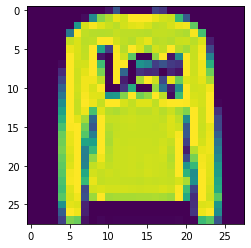

In [319]:
plt.imshow(test_x[1,:])

In [338]:
DG = DataGenerator_array(test_x, 
                         #test_y,
                         to_fit = True,
                         dim = (28,28),
                         shuffle = False,
                    
                        )

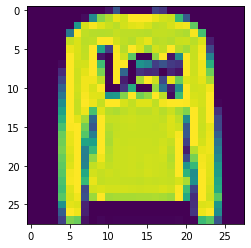

In [339]:
RR = DG[0]
RR[1]
plt.imshow(RR[1][1].reshape(28,28))

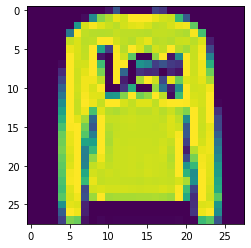

In [340]:
plt.imshow(RR[0][1].reshape(28,28))

In [232]:
ZZ[ZZ<0.71] = 0

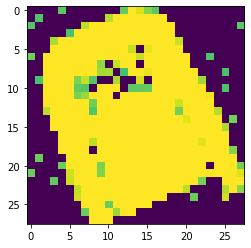

In [233]:
plt.imshow(ZZ.reshape(28,28))